# Eval VAE
### Imports

In [1]:
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging, torchviz
# Base Scripts
from Libraries.VAE import *
from Libraries.Utils import *
from Conf import *

### Config

In [2]:
model_name: str = "conv_VAE_v2"
training_data_name: str = "training_640"
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Functions

In [3]:
def generate_data(model: nn.Module, device: str,  n_samples: int = 1, seed: ndarray = None, file_name: str = "test") -> None:
    model.eval()
    if seed is not None:
        save_audio_file(spectrogram_to_audio(unnormalize(seed), LEN_FFT), f"{RESULT_PATH}/{file_name}_seed.wav")
        samples = generate_sample(model, device, Tensor(seed).view(1, 1, seed.shape[-2], seed.shape[-1]), num_samples=n_samples)
    else:
        samples = generate_sample(model, device, num_samples=n_samples)
    for i in range(samples.shape[1]):
        save_audio_file(spectrogram_to_audio(unnormalize(samples[0,i]), LEN_FFT), f"{RESULT_PATH}/{file_name}_{i:02d}.wav", SAMPLE_RATE)
    logger.light_debug(f"Saved {samples.shape[0]} samples to {RESULT_PATH}")


def pass_through(model: nn.Module, device: str, sample: ndarray, file_name: str = "test") -> None:
    visualize_spectogram(sample)
    save_audio_file(spectrogram_to_audio(unnormalize(sample), LEN_FFT), f"{RESULT_PATH}/{file_name}_inp.wav")
    x = fwd_pass(model, device, Tensor(sample).view(1, 1, sample.shape[-2], sample.shape[-1]))
    visualize_spectogram(x[0,0])
    audio = spectrogram_to_audio(unnormalize(x[0,0]), LEN_FFT)
    save_audio_file(audio, f"{RESULT_PATH}/{file_name}_out.wav")
    logger.light_debug(f"Saved passed through sample to {RESULT_PATH}")

### Data Loading & Model Creation

In [4]:
file = load_training_data(f"{DATA_PATH}/{training_data_name}.npy")
logger.info(f"Data loaded with shape: {file.shape}")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VAE(in_channels=1, latent_dim=256, device=device,input_shape=[0,0, file.shape[-2], file.shape[-1]], n_conv_blocks=1, n_starting_filters=64, lin_bottleneck=False).to(device)
model.load_state_dict(torch.load(f"{MODEL_PATH}/{model_name}.pth", map_location=device, weights_only=False))

2025-02-26 09:35:36,621 - INFO - Data loaded with shape: (640, 1024, 672)


<All keys matched successfully>

### Evaluation

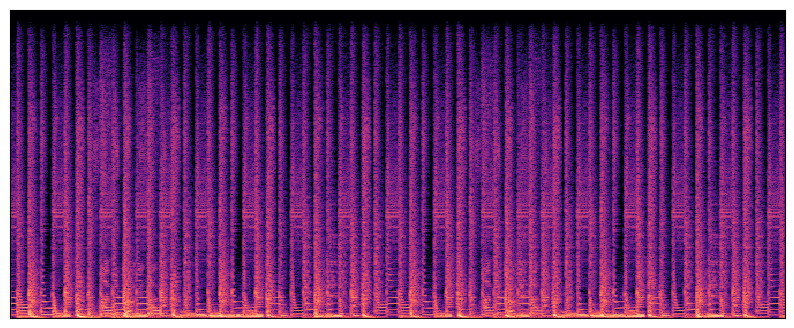

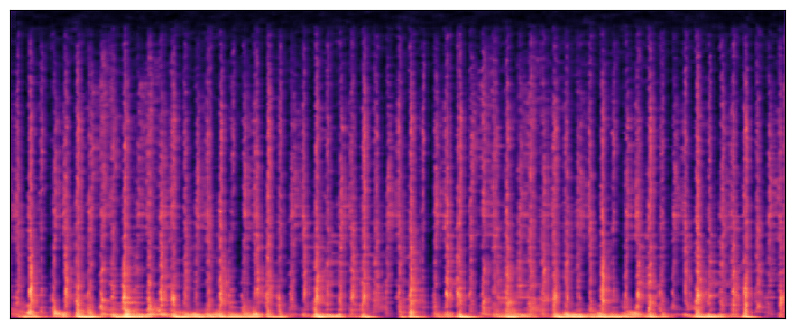

In [5]:
#generate_data(model=model,device=device, seed=file[600])
pass_through(model, device, file[300])

### Export Model Architecture

In [ ]:
#torch.onnx.export(model, torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1]), f"{RESULT_PATH}/{model_name}.onnx", opset_version=11) #Currently not working
model.eval()
with torch.no_grad():
    script_model = torch.jit.trace(model, torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1]), check_trace=False)
torch.jit.save(script_model, f"{RESULT_PATH}/{model_name}.pt")
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
logger.info(f"Saved model {RESULT_PATH}/{model_name}.pt")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH